setup: open trades database and table epex_12_20_12_13

# FlexPower Interview tasks -- Testbook

## Task 1 Minimal reporting tool

### set up and data import

In [1]:
#PYTHON 3.9.6

In [142]:
import sqlite3
import pandas as pd
import numpy as np
import statistics as stats

In [4]:
con = sqlite3.connect("trades.sqlite")
trades = pd.read_sql_query("SELECT * from epex_12_20_12_13", con)
#TODO: check this is reading all of them in
print(trades.head())
con.close()
print(trades.size, trades.shape)

        id  quantity  price  side    strategy
0  trade_1         5   20.0   buy  strategy_1
1  trade_2        17   10.0  sell  strategy_1
2  trade_3        15    8.0   buy  strategy_1
3  trade_4        13   35.0  sell  strategy_2
4  trade_5        23   11.0  sell  strategy_2
30 (6, 5)


In [5]:
print(trades)

        id  quantity  price  side    strategy
0  trade_1         5   20.0   buy  strategy_1
1  trade_2        17   10.0  sell  strategy_1
2  trade_3        15    8.0   buy  strategy_1
3  trade_4        13   35.0  sell  strategy_2
4  trade_5        23   11.0  sell  strategy_2
5  trade_6         8   20.0   buy  strategy_2


In [6]:
#TODO: quick data cleaner making sure evth is in the right type

### Task 1.1
Write a function that computes the total buy volume for flex power, another that computes the total sell volume.

In [7]:

def compute_total_buy_volume(tradetable) -> float:
    total_buy = tradetable[tradetable.side == 'buy'].quantity.sum()
    return total_buy

def compute_total_sell_volume(tradetable) -> float:
    total_sell = tradetable[tradetable.side == 'sell'].quantity.sum()
    return total_sell

In [8]:
compute_total_buy_volume(trades)
compute_total_sell_volume(trades)

np.int64(53)

In [9]:
#TODO: change to dataframe.filter for efficiency (in case tested on a bigger database)

### Task 1.2
PnL calculation for each strategy; defn sum of incomes, with selling +ve and buying -ve

In [10]:
print(trades.strategy.unique())

['strategy_1' 'strategy_2']


In [11]:
def compute_pnl(strategy_id: str, tradetable) -> float:
    if strategy_id in tradetable.strategy.unique():
        this_strategy_trades_sell = tradetable[(tradetable.strategy == strategy_id) & (tradetable.side == 'sell')]
        this_strategy_trades_buy = tradetable[(tradetable.strategy == strategy_id) & (tradetable.side == 'buy')]
        sales = this_strategy_trades_sell.quantity * this_strategy_trades_sell.price
        sales_value = sales.sum()
        buys = this_strategy_trades_buy.quantity * this_strategy_trades_buy.price
        buys_value = buys.sum()
        income = sales_value - buys_value
    else:
        income = 0
    return income
#make this smarter anad use the buy sell volume funcs from above?
#use .dot explicityly rather than *? check know behaviour of this?
#change to not do memory allocation (change to a lambda function? rather than data slicing?

In [126]:
print(compute_pnl('strategy_2',trades),
compute_pnl('strategy_1',trades),
compute_pnl('strategy_0',trades))

548.0 -50.0 0


### Task 1.3
expose compute_pnl as the entrypoint of a web application

import requests as rq

class Api:
    def compute_pnl(strategy_id: str, tradetable) -> float:
        if strategy_id in tradetable.strategy.unique():
            this_strategy_trades_sell = tradetable[(tradetable.strategy == strategy_id) & (tradetable.side == 'sell')]
            this_strategy_trades_buy = tradetable[(tradetable.strategy == strategy_id) & (tradetable.side == 'buy')]
            sales = this_strategy_trades_sell.quantity * this_strategy_trades_sell.price
            sales_value = sales.sum()
            buys = this_strategy_trades_buy.quantity * this_strategy_trades_buy.price
            buys_value = buys.sum()
            income = sales_value - buys_value
        else:
            income = 0
        return income

from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route("/pnl/<strategy_id>")
def compute_pnl(strategy_id: str, tradetable) -> float:
        if strategy_id in tradetable.strategy.unique():
            this_strategy_trades_sell = tradetable[(tradetable.strategy == strategy_id) & (tradetable.side == 'sell')]
            this_strategy_trades_buy = tradetable[(tradetable.strategy == strategy_id) & (tradetable.side == 'buy')]
            sales = this_strategy_trades_sell.quantity * this_strategy_trades_sell.price
            sales_value = sales.sum()
            buys = this_strategy_trades_buy.quantity * this_strategy_trades_buy.price
            buys_value = buys.sum()
            income = sales_value - buys_value
        else:
            income = 0
        return jsonify(income),200

can't figure out how to do this yet; move on and check back in later

## Task 2

### Set up and data imports

In [14]:
import openpyxl

In [15]:
task2df = pd.read_excel('analysis_task_data.xlsx',sheet_name='DE_Wind_PV_Prices')

In [16]:
print(task2df.size,task2df.shape)

350400 (35040, 10)


In [17]:
task2df.shape[0]/365/24/4

1.0

In [18]:
task2df.columns

Index(['hour', 'time', 'Wind Day Ahead Forecast [in MW]',
       'Wind Intraday Forecast [in MW]', 'PV Day Ahead Forecast [in MW]',
       'PV Intraday Forecast [in MW]', 'Day Ahead Price hourly [in EUR/MWh]',
       'Intraday Price Price Quarter Hourly  [in EUR/MWh]',
       'Intraday Price Hourly  [in EUR/MWh]',
       'Imbalance Price Quarter Hourly  [in EUR/MWh]'],
      dtype='object')

### Task 2.1
How much Wind/PV Power was forecasted to produced in German in 2021 [in MWh] on Day Ahead (da) and on Intraday (id). Hint: Be careful: you have values in MW on a quarter hourly basis, think how this translates into hourly values.

In [19]:
da_wind_forecast_total_mwh = task2df['Wind Day Ahead Forecast [in MW]'].sum()/4
print(da_wind_forecast_total_mwh)

115395406.25


In [20]:
da_pv_forecast_total_mwh = task2df['PV Day Ahead Forecast [in MW]'].sum()/4
print(da_pv_forecast_total_mwh)

46094572.75


In [21]:
id_wind_forecast_total_mwh = task2df['Wind Intraday Forecast [in MW]'].sum()/4
print(id_wind_forecast_total_mwh)

113478034.5


In [22]:
id_pv_forecast_total_mwh = task2df['PV Intraday Forecast [in MW]'].sum()/4
print(id_pv_forecast_total_mwh)

46689891.5


In [24]:
#2 graphs of forecast production for wind and solar da and id
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)

axis[0, 0].plot(X, )
axis[0, 0].plot(X, )
axis[0, 0].set_title("Solar production forecasts (Cumulative, MWh)")

axis[0, 1].plot(X, )
axis[0, 1].set_title("Wind production forecasts (Cumulative, MWh)")

### Task 2.2
Show the average Wind/Solar production for 2021 over a 24h period for Intraday and Day Ahead (4 lines in one graph).

In [25]:
import numpy as np

In [26]:
#find the average wind production in a 24h period on da
#have the hour of the day; group by hour, take the average for that hour, remember /4
da_wind_24h_av_production = task2df.groupby(by='hour').agg({'Wind Day Ahead Forecast [in MW]':'mean'}).reindex()
da_wind_24h_av_production = da_wind_24h_av_production['Wind Day Ahead Forecast [in MW]'] / 4
#print(da_wind_24h_av_production)

In [27]:
#find the average wiind production in a 24h period on id
id_wind_24h_av_production = task2df.groupby(by='hour').agg({'Wind Intraday Forecast [in MW]':'mean'}).reindex()
id_wind_24h_av_production = id_wind_24h_av_production['Wind Intraday Forecast [in MW]'] / 4

In [28]:
#find the 24h average solar production in a 24 h period on da
da_solar_24h_av_production = task2df.groupby(by='hour').agg({'PV Day Ahead Forecast [in MW]':'mean'}).reindex()

In [29]:
#find the average solar production in a 24h period on id

In [30]:
#create a new dataframe grouped by hour with the mean of each hour
av_24h = task2df.groupby(by='hour').agg({'Wind Day Ahead Forecast [in MW]':'mean',
                                         'Wind Intraday Forecast [in MW]':'mean',
                                         'PV Day Ahead Forecast [in MW]':'mean',
                                         'PV Intraday Forecast [in MW]':'mean'}).reindex()
#print(av_24h.index)
#print(av_24h.head(2))
av_24h = av_24h/4
#print(av_24h.head(2))

Text(0, 0.5, 'Average production (MW)')

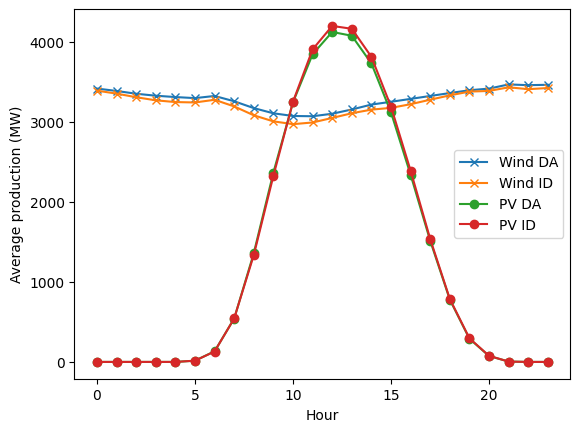

In [31]:
#plot all 4 on the same graph
X = av_24h.index
plt.plot(X, av_24h['Wind Day Ahead Forecast [in MW]'],label='Wind DA',marker='x')
plt.plot(X, av_24h['Wind Intraday Forecast [in MW]'], label='Wind ID',marker='x')
plt.plot(X, av_24h['PV Day Ahead Forecast [in MW]'], label='PV DA',marker='o')
plt.plot(X, av_24h['PV Intraday Forecast [in MW]'], label='PV ID',marker='o')
plt.legend(loc='center right')
plt.xlabel("Hour")
plt.ylabel("Average production (MW)")

### Task 2.3 
What was the average value [in EUR/MWh] for Wind/Solar Power in 2021 using the da forecast and using da h prices? The average value is defined as the average hourly value that a Wind/PV farm owner would have received for their product. Is the average value of Wind and PV higher or lower than the average da price? Why could it be higher/lower?

In [32]:
#average da price (cancels out that is repeated 4 times in each quarter)
av_da_price = task2df['Day Ahead Price hourly [in EUR/MWh]'].mean()
print(av_da_price)

96.84991780821919


#average value is sum DA forecast * dah price / count (do i exclude zero hours?); don't forget in 15mins not hrs
wind_produced = task2df[task2df['Wind Day Ahead Forecast [in MW]']>0]
wind_produced['value'] = 0.25*wind_produced['Wind Day Ahead Forecast [in MW]']*wind_produced['Day Ahead Price hourly [in EUR/MWh]']
#hours * MW * EUR/MWh = EUR
av_wind_value = wind_produced.value.sum()/(wind_produced['Wind Day Ahead Forecast [in MW]'].sum()*0.25)
#EUR / MW*hours
print(av_wind_value)

In [33]:
#wind and solar average values are going to be weighted averages based on production in certain hours aat price x

In [34]:
av_wind_value_da = (0.25*task2df['Wind Day Ahead Forecast [in MW]']*task2df['Day Ahead Price hourly [in EUR/MWh]']).sum()/(0.25*task2df['Wind Day Ahead Forecast [in MW]'].sum())

In [35]:
print(av_wind_value_wzeroes)

NameError: name 'av_wind_value_wzeroes' is not defined

In [261]:
#makes no difference having zeroes

In [36]:
av_pv_value_da = (0.25*task2df['PV Day Ahead Forecast [in MW]']*task2df['Day Ahead Price hourly [in EUR/MWh]']).sum()/(0.25*task2df['PV Day Ahead Forecast [in MW]']).sum()

In [37]:
print(av_pv_value_da)

76.89453079034125


Solar average price is 76.89 EUR/MWh (2sf); wind is approx 81.38 EUR/MWh (2sf); the average da h value for contrast is 96.84 EUR/MWh (2sf)
The average prices are lower because wind and solar are low marginal cost; when they are producing, they bring the price of electricity down. This is even more apparent when they are producing lots of power; the more of the required power they supply, the lower the price in a system where the day ahead price is set using a merit order

### Task 2.4
Find the Day with the highest renewable energy production and with the lowest renewable energy production in 2021. What was the average Day Ahead Price levels on these days? How do you explain the difference in prices?

In [38]:
#time column is a timestamp type
task2df['day'] = pd.to_datetime(task2df.time).dt.date
#print(task2df.tail(2))

In [39]:
print(task2df.columns)

Index(['hour', 'time', 'Wind Day Ahead Forecast [in MW]',
       'Wind Intraday Forecast [in MW]', 'PV Day Ahead Forecast [in MW]',
       'PV Intraday Forecast [in MW]', 'Day Ahead Price hourly [in EUR/MWh]',
       'Intraday Price Price Quarter Hourly  [in EUR/MWh]',
       'Intraday Price Hourly  [in EUR/MWh]',
       'Imbalance Price Quarter Hourly  [in EUR/MWh]', 'day'],
      dtype='object')


In [40]:
data_by_day = task2df.groupby(by='day').agg({'Wind Day Ahead Forecast [in MW]':'sum',
                                             'Wind Intraday Forecast [in MW]': 'sum',
                                             'PV Day Ahead Forecast [in MW]':'sum',
                                             'PV Intraday Forecast [in MW]':'sum',
                                             'Day Ahead Price hourly [in EUR/MWh]':'mean',
                                             'Intraday Price Price Quarter Hourly  [in EUR/MWh]':'mean',
                                             'Intraday Price Hourly  [in EUR/MWh]':'mean',
                                             'Imbalance Price Quarter Hourly  [in EUR/MWh]':'mean'}).reindex()

In [41]:
day_max_wind_prod_da = data_by_day.sort_values(by='Wind Day Ahead Forecast [in MW]',ascending=False).index[0]
day_max_wind_prod_da_price = data_by_day.sort_values(by='Wind Day Ahead Forecast [in MW]',ascending=False).iloc[0]['Day Ahead Price hourly [in EUR/MWh]']
print(day_max_wind_prod_da,day_max_wind_prod_da_price)

2021-10-21 61.50333333333333


In [42]:
day_min_wind_prod_da = data_by_day.sort_values(by='Wind Day Ahead Forecast [in MW]',ascending=True).index[0]
day_min_wind_prod_da_price = data_by_day.sort_values(by='Wind Day Ahead Forecast [in MW]',ascending=True).iloc[0]['Day Ahead Price hourly [in EUR/MWh]']
print(day_min_wind_prod_da,day_min_wind_prod_da_price)

2021-06-26 79.875


In [43]:
day_max_pv_prod_da = data_by_day.sort_values(by='PV Day Ahead Forecast [in MW]',ascending=False).index[0]
day_max_pv_prod_da_price = data_by_day.sort_values(by='PV Day Ahead Forecast [in MW]',ascending=False).iloc[0]['Day Ahead Price hourly [in EUR/MWh]']
print(day_max_pv_prod_da,day_max_wind_prod_da_price)

2021-06-14 61.50333333333333


In [44]:
day_min_pv_prod_da = data_by_day.sort_values(by='PV Day Ahead Forecast [in MW]',ascending=True).index[0]
day_min_pv_prod_da_price = data_by_day.sort_values(by='PV Day Ahead Forecast [in MW]',ascending=True).iloc[0]['Day Ahead Price hourly [in EUR/MWh]']
print(day_min_pv_prod_da,day_min_pv_prod_da_price)

2021-01-06 52.68291666666667


Explain the difference:

High solar and wind production levels push higher marginal cost generation methods out of the merit order and lower the price.

In [45]:
#graph / faked up merit order that shows this

### Task 2.5 
What is the average hourly da price during week days vs during weekends. Why do you think average prices may differ?

In [46]:
task2df['day of week'] = pd.to_datetime(task2df.time).dt.dayofweek

In [47]:
av_da_weekday_price = task2df[task2df['day of week'] <= 5]['Day Ahead Price hourly [in EUR/MWh]'].mean()
print(av_da_weekday_price)

101.21392705005326


In [48]:
av_da_weekend_price = task2df[task2df['day of week'] >5]['Day Ahead Price hourly [in EUR/MWh]'].mean()
print(av_da_weekend_price)

70.58193910256409


Why does the average differ?

Demand is (usually!) lower on the weekends; the cut off boundary therefore falls lower on the merit order curve and the price is lower.

### Task 2.6

How much revenue would you generate with a battery with a capacity of 1 MWh which you can fully charge and fully discharge (1 Cycle) every day in 2021? Think about when you would charge and when you would discharge and apply this rule for each day of the year.

In [ ]:
#assuming can only fully charge and discharge the once?
#assume that low price and high price alternate neatly...
#rule: charge at lowest price of the day ahead and sell at highest price on the intraday

In [50]:
#regroupby dataframe by day and add two new columns min price and max price
#third column of the difference between these
#add up this difference over the year
task2df['minprice'] = task2df['Day Ahead Price hourly [in EUR/MWh]']*1
task2df['maxprice'] = task2df['Intraday Price Hourly  [in EUR/MWh]']*1
task26 = task2df.groupby(by='day').agg({'minprice':'min',
                                        'maxprice':'max'})
print(task26.head(2))

            minprice   maxprice
day                            
2021-01-01     39.63  62.996242
2021-01-02     37.55  62.220613


In [51]:
task26['max price difference'] = task26['maxprice']-task26['minprice']
earnings = task26['max price difference'].sum()
print(earnings)

30564.964930669164


In [52]:
# can take this as a maximum; instead sorting by hour and making sure that they alternate...


### Task 2.7

Come up with a trading strategy that makes money between the day ahead hourly prices and the intraday hourly prices. A strategy could be something like, always buy hour 19-20 on day ahead and sell it on intraday. You can look at certain times, weekdays, seasons, production levels of wind and solar. Your strategy can have a few input paramters such as time, renewable production etc, and then a decision output between two prices. I.e. when do you want to go long and short. Show the cumulative performance of this strategy with a 100 MW position. Show your results and quickly explain your reasoning of why you think this strategy might be a good idea and why it does or does not work.

#### My assumptions:

(1) 100MW is a small volume compared to hourly power flows and therefore my trading activity doesn't affect prices

(2) My strategies will perform the same (relative rate of return, risk etc) regardless of if applied to 1 MW or 100 MW. 

Additionally:
I've defined my price difference as that between the Day Ahead hourly and the Intraday hourly prices (DA - ID = difference)
I understand a 'long' position as buy on DA sell on ID --> day ahead is lower than intraday --> price imbalance variable is -ve

and 'short' --> sell DA buy ID --> day ahead is higher than ID --> price imbalance is +ve

#### My approach:

Two sides to my approach -- what does the data show and what does theory tell me?

*Theory* tells me the DA price will differ from the ID where the day ahead forecast differs from the intraday. The forecast will differ when:
- uncertainty in the renewables production forecast (weather is a chaotic system, weather models are not perfect)
- the demand forecast changes unexpectedly because this forecast was flawed
- an event causes supply to change in a way unpredictable by the forecast (eg line outage)

Production forecast uncertainty will be highest when either renewable production is higher (as renewables are more uncertain than dispatchable power) or when there's higher uncertainty in the renewables forecast specifically (eg at the start or end of a weather front, cloudy weather...). I don't know anything about the forecast models used here -- therefore I can only make general inferences about where these uncertainties lie.

Similarly, I can't make many inferences about the demand modelling and where it may change suddenly. Perhaps I could model back from where the price varied dramatically between DA and ID without a commensurate difference in the DA and ID renewables forecast; this will be tricky. However, the biggest impact on prices of a demand forecasting problem is likely to be when demand is high. This could indicate going long on days when demand is higher; it depends whether demand forecasts tend to err high or low. I'm not going to look at it in this case, as I judge the uncertainty in the renewables forecast to be the more likely and therefore fruitful.

I can't predict an event like an unplanned failure from past data. I can however target times at which prices are particularly vulnerable to such events. Doing this is likely to be involved and I'm going to rule it out of scope.

If I were to use a theory --> strategy approach, I would look for times and circumstances in which the inherent uncertainty in the wind and solar forecast is higher, or when renewables are high and therefore a greater share of the generation stack is subject to that uncertainty.

My approach to do this with the information provided would be:
...

*Data* can tell me empirically what strategies work and don't work... in 2021. To use these strategies, I need to understand whether the strategies designed from data owe their performance to the strategy itself, or the circumstances of 2021. I would use statistics to assess this, as I have below.

On consideration of the scope, time and data available, I've decided to start with the data led approach here.

--
Additionally, if I had the time and the information to do so, I would prefer to look at the carbon impact of trading strategies and how I can use them to push gas out of the market.

#### Data Analysis

For the year as a whole, what is the difference between DA and ID (hourly) prices? (how much is there to potentially be made?)

In summary, my process for building a strategy would be:
- identify patterns in the data on price difference between DA and ID
- make statements which turn these patterns into positions
- assess the value of these positions
- assess the risk of these positions
- combine several statements/trades into a strategy which, ideally, balances risk

I've defined my price difference as that between the Day Ahead hourly and the Intraday hourly prices.

In [145]:
task2df['price_imbalance'] = task2df['Day Ahead Price hourly [in EUR/MWh]']-task2df['Intraday Price Hourly  [in EUR/MWh]']


go long --> buy DA sell ID --> day ahead is lower than intraday --> price imbalance variable is -ve

go short --> sell DA buy ID --> day ahead is higher than  --> price imbalance is +ve

In [150]:
long = -1
short = 1

In [146]:
print('sum:',task2df.price_imbalance.sum(),
      'modulus',task2df.price_imbalance.abs().sum(),
      'mean',task2df.price_imbalance.mean(),
      'mode',stats.mode(task2df.price_imbalance),
      'stddev', task2df.price_imbalance.std())

sum: -39895.754653392614 modulus 355004.4217998296 mean -1.138577472984949 mode 2.187706417097999 stddev 16.381295199425658


=> if I could find the Ultimate Strategy that perfectly predicted the discrepancy between DA and ID for all hours, this strategy would make 355k euros per MWh of position (the absolute sum of the price difference for each hour in 2021)

=> the mean is negative (-1.13)=> DA is on average < ID prices => if I just went long on every hour of every day, I would make...

In [151]:
print(task2df.price_imbalance.mean()*365*24*long)

9973.938663348154


9974 Euros per MWh of my position (but with a lot of ups and downs on the way!)

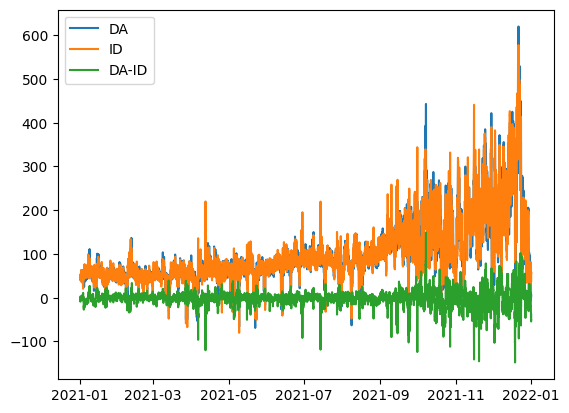

In [148]:
plt.plot(task2df['time'],task2df['Day Ahead Price hourly [in EUR/MWh]'],label='DA')
plt.plot(task2df['time'],task2df['Intraday Price Hourly  [in EUR/MWh]'],label='ID')
plt.plot(task2df.time,task2df.price_imbalance,label='DA-ID')
plt.legend()
plt.show()

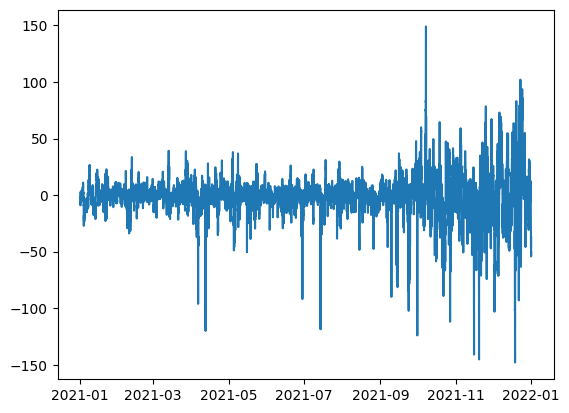

In [97]:
plt.plot(task2df['time'],task2df['price_imbalance'])
plt.show()

Looking at the plot of the data for the whole year, prices rise after September, and the range in price increases. The price difference available for capture between DA and ID also increases, and the range also increases

From this data alone, it would seem worth splitting my analysis into pre and post September; however, I suspect this additional noise and higher prices is actually due to the increase in gas prices that occured, and therefore due to this being data from 2021 rather than any underlying pattern

Within a day, the value available for capture in different hours is:

In [179]:
byhour = task2df.groupby('hour').agg({'price_imbalance':'mean'}).reindex()
byhour_stddev = task2df.groupby('hour').agg({'price_imbalance':'std'}).reindex()

Assuming for now that the distribution of prices for each hour of the day is normal (will check for interesting hours later)

DO FREQUENCY DISTRIBUTIONS FOR EACH HOUR

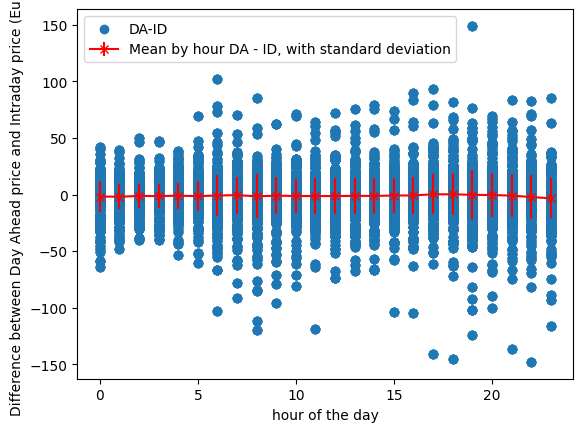

In [183]:
plt.scatter(task2df['hour'],task2df['price_imbalance'],marker='o',label='DA-ID')
plt.errorbar(byhour.index,byhour['price_imbalance'],marker='x',label='Mean by hour DA - ID, with standard deviation',yerr=byhour_stddev['price_imbalance'],color='r')
plt.xlabel('hour of the day')
plt.ylabel('Difference between Day Ahead price and Intraday price (Euros)')
plt.legend()
plt.show()

Which hour on average has the best spread (mean)? If I just take a simple position every day on this hour, what does this strategy earn?

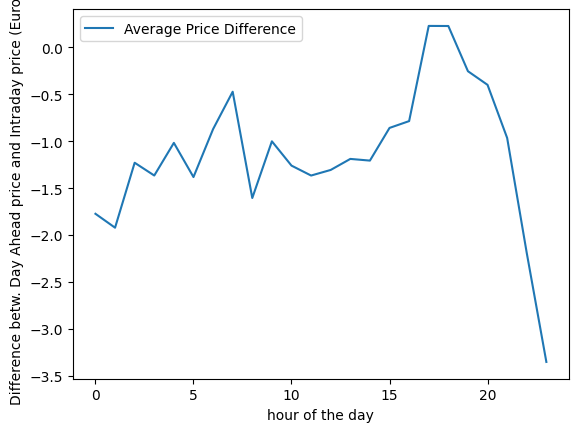

In [185]:
plt.plot(byhour.index,byhour.price_imbalance,label='Average Price Difference')
plt.xlabel('hour of the day')
plt.ylabel('Difference betw. Day Ahead price and Intraday price (Euros)')
plt.legend()
plt.show()

Of all the hours of the day, hour 23 has on (mean) average the greatest difference between the Day Ahead and Intraday price => taking a position on this hour will earn the most

In [186]:
print(byhour.price_imbalance.max())
print(byhour.price_imbalance.min())

0.2270704813504371
-3.350564933398728


The price difference is -ve => Day ahead is cheaper than ID => go long

If I did this at 11pm every day for each day of 2021, I would have earnt:

In [187]:
#expect to make on average over the year:
earnings = byhour.price_imbalance.min()*365*long
print(earnings, "per 1MWh of position")

1222.9562006905358 per 1MWh of position


A total of 1222.96 Euros per MWh of my position

In [188]:
#check this -- make sure doing /4 because will be in 1/4 hours
hour23 = task2df[task2df['hour']==23]
print(hour23.price_imbalance.sum()/4*long)

1222.9562006905358


To make this trade every day, I would have needed approximately:

In [189]:
investment = 365*task2df[task2df['hour']==23]['Day Ahead Price hourly [in EUR/MWh]'].mean() #investment required per MWh of position
#going long == buying on DA
print(investment)

30971.260000000002


In [123]:
print(earnings/investment*100,"%")


3.9486808114701684 %


31k euros of starting capital and would have made a 3.95% return.

In [192]:
gains = hour23[hour23.price_imbalance < 0]['price_imbalance'].sum()/4
losses = hour23[hour23.price_imbalance > 0]['price_imbalance'].sum()/4
print(gains, losses, gains+losses)

-2511.384034351591 1288.4278336610555 -1222.9562006905353


Along the way I would have made 2511.38 Euros and lost 1288.43.

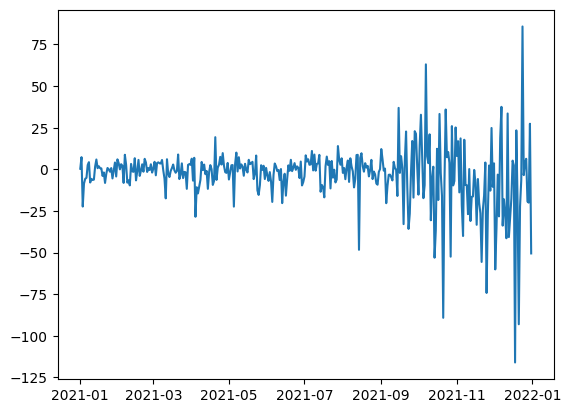

In [ ]:
plt.plot(hour23['day'],hour23['price_imbalance'])
plt.show()

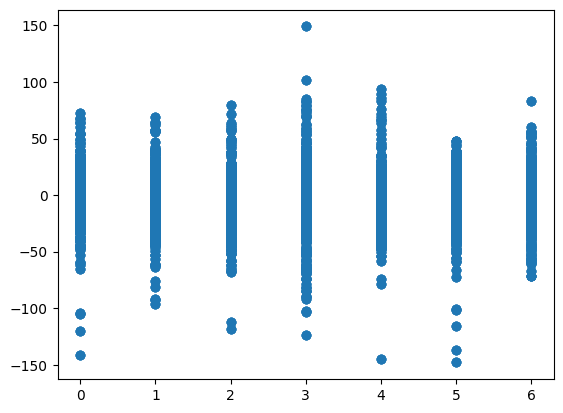

In [60]:
plt.scatter(task2df['day of week'],task2df['price_imbalance'],marker='o')
plt.show()

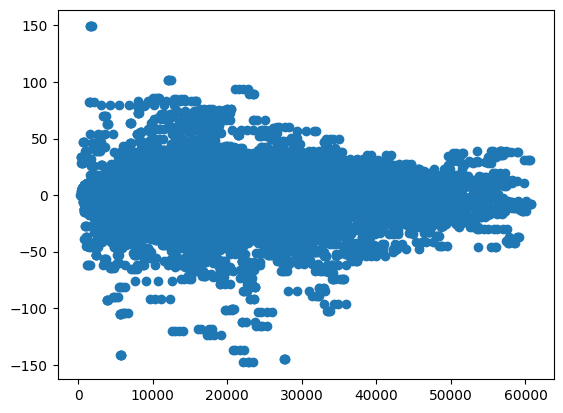

In [149]:
#first, make a scatter of the difference between intraday and day ahead for each hour
task2df['price_imbalance'] = task2df['Day Ahead Price hourly [in EUR/MWh]']-task2df['Intraday Price Hourly  [in EUR/MWh]']
task2df['renewables'] = task2df['PV Intraday Forecast [in MW]']+task2df['Wind Intraday Forecast [in MW]']
plt.scatter(task2df['renewables'],task2df['price_imbalance'],marker='o')
plt.show()

compare mean to modal to rule out an anomaly draggin up my average; box plot to check IQR

add a mechanism for evaluating when to go long or short

find price range of when imbalance -ve and when is +ve


what fraction of the time is id above da? for different hours?

do i only do it up to sept?

is it wind conditions/solar?

how does my strategy behave when i don't have perfect information? is the best strategy the one i understand the best, not the one that performs the best?